# First order methods for ML models

## Aim

<div class="alert alert-block alert-info"> 
    The aim of this material is to code <br>
- gradient descent (GD) <br>
- accelerated gradient descent via Nesterov (AGD) or Heavy Ball (HB) <br>
- stochastic gradient descent (SGD) <br>
- better stochastic methods <br>


for **linear** and **logistic** regressions (both with potentially a 
ridge regularization).
</div>




## To generate the name of your file, use the following

In [1]:
# Change here using your first and last names
fn1 = "bonnie"
ln1 = "parker"
fn2 = "clyde"
ln2 = "barrow"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp1_parker_bonnie_and_barrow_clyde.ipynb


# Table of content

[1. Introduction](#intro)<br>
[2. Models gradients and losses](#models)<br>
[3. Solvers](#solvers)<br>
[4. Comparison of all algorithms](#comparison)<br>

<a id='intro'></a>
# 1. Data from a linear model

## 1.1. Getting model weights

We start by simulating data.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

## 1.2. Simulation of a linear model

In [3]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(w0, n_samples=1000, corr=0.5, std=0.5):
    """Simulation of a linear regression model with Gaussian features
    and a Toeplitz covariance, with Gaussian noise.
    
    Parameters
    ----------
    w0 : `numpy.array`, shape=(n_features,)
        Model weights
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features
    
    std : `float`, default=0.5
        Standard deviation of the noise

    Returns
    -------
    X : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It contains samples of a centered 
        Gaussian  vector with Toeplitz covariance.
    
    y : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    n_features = w0.shape[0]
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    X = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    y = X.dot(w0) + std * randn(n_samples)
    return X, y

/tmp/ipykernel_158290/2152093789.py:2: DeprecationWarning: Please use `toeplitz` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import toeplitz


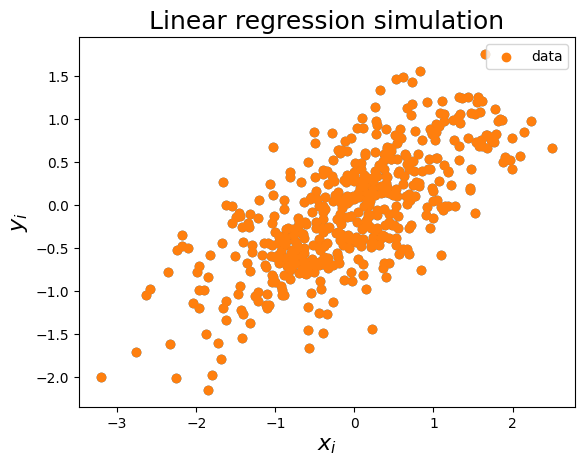

In [4]:
n_samples = 500
w0 = np.array([0.5]) # 1D here...

X, y = simu_linreg(w0, n_samples=n_samples, corr=0.3, std=0.5)
plt.scatter(X, y)
plt.xlabel(r"$x_i$", fontsize=16)
plt.ylabel(r"$y_i$", fontsize=16)
plt.title("Linear regression simulation", fontsize=18)
plt.scatter(X, y, label='data')
plt.legend()

<a id='models'></a>
# 2. Model gradient and loss

We want to minimize a goodness-of-fit function $f$ with ridge regularization, namely
$$
\arg\min_{w \in \mathbb R^d} \Big\{ f(w) + \frac{\lambda}{2} \|w\|_2^2 \Big\}
$$
where $d$ is the number of features and where we will assume that $f$ is $L$-smooth.
We will consider below the following case:

**Linear regression**, where 
$$
f(w) = \frac 1n \sum_{i=1}^n f_i(w) = \frac{1}{2n} \sum_{i=1}^n (y_i - x_i^\top w)^2 + \frac{\lambda}{2} \|w\|_2^2 = \frac{1}{2 n} \| y - X w \|_2^2 + \frac{\lambda}{2} \|w\|_2^2,
$$
where $n$ is the sample size, $y = [y_1 \cdots y_n]$ is the vector of labels and $X$ is the matrix of features with lines containing the features vectors $x_i \in \mathbb R^d$.


We need to be able to compute $f(w)$ and its gradient $\nabla f(w)$, in order to solve this problem, as well as $\nabla f_i(w)$ for stochastic gradient descent methods and $\frac{\partial f(w)}{\partial w_j}$ for coordinate descent.



## 2.1 Linear regression


<div class="alert alert-block alert-warning"> Complete the code below to compute loss and gradient in the case of linear regression </div>

In [31]:
from numpy.linalg import norm


class ModelLinReg:
    """A class giving first order information for linear regression
    with least-squares loss
    
    Parameters
    ----------
    X : `numpy.array`, shape=(n_samples, n_features)
        The features matrix
    
    y : `numpy.array`, shape=(n_samples,)
        The vector of labels
    
    strength : `float`
        The strength of ridge penalization
    """    
    def __init__(self, X, y, strength):
        self.X = X
        self.y = y
        self.strength = strength
        self.n_samples, self.n_features = X.shape
    
    def predict(self, w):
        return 

    def loss(self, w):
        """Computes f(w)"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        ### TODO
        return (1/(2*self.n_samples)) * norm(y - X@w, 2)**2 + (self.strength / 2) * norm(w, 2)**2
        ### END TODO
        
    def grad(self, w):
        """Computes the gradient of f at w"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        ### TODO
        return (1/self.n_samples) * -X.T @ (y - X@w) + self.strength * w
        ### END TODO
        
#   # (LATER)         
#    def grad_i(self, i, w):
#        """Computes the gradient of f_i at w"""
#        x_i = self.X[i]
#        ### TODO
#
#        ### END TODO

#    # MAYBE LATER IF YOU ARE BORED
#    def grad_coordinate(self, j, w):
#        """Computes the partial derivative of f with respect to 
#        the j-th coordinate"""
#        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
#        ### TODO
#   
#        ### END TODO

    def lip(self):
        """Computes the Lipschitz constant of grad f"""
        X, n_samples = self.X, self.n_samples
        # Norm inf de la matrice hessienne
        ### TODO
        return norm((1/n_samples) * X.T @ X, np.inf)
        return (1/n_samples) * norm(X.T @ X, -2) + self.strength # ???
        ### END TODO
        
        
        
#    # MAYBE LATER IF YOU ARE BORED
#    def lip_coordinates(self):
#        """Computes the Lipschitz constant of the derivative of f^j (f with respect to 
#        the j-th coordinate)"""
#        X, n_samples = self.X, self.n_samples
#        ### TODO
#
#        ### END TODO
        
    # def lip_max(self):
    #     """Computes the maximum of the lipschitz constants of f_i"""
    #     X, n_samples = self.X, self.n_samples
    #     ### TODO

    #     ### END TODO

## 2.2 Checks for the linear regression model

Text(0.5, 1.0, 'Model weights')

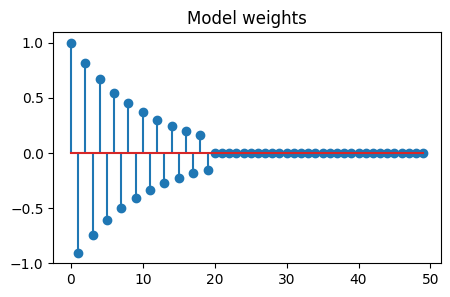

In [32]:
## Simulation setting
n_features = 50
nnz = 20
idx = np.arange(n_features)
w_true = (-1) ** idx * np.exp(-idx / 10.)
w_true[nnz:] = 0.

plt.figure(figsize=(5, 3))
plt.stem(w_true)
plt.title("Model weights")

<div class="alert alert-block alert-warning"> Check your implementation by comparing your computation to what you would have obtained with autograd. </div>

In [33]:
from scipy.optimize import check_grad

X, y = simu_linreg(w_true, corr=0.6)
model = ModelLinReg(X, y, strength=1e-3)
w = np.random.randn(n_features)

print(check_grad(model.loss, model.grad, w)) # This must be a number (of order 1e-6)

3.864975856783737e-06


In [34]:
print("lip=", model.lip())
# print("lip_max=", model.lip_max())
# print("lip_coordinates=", model.lip_coordinates())

lip= 5.624989098370818


<a id='solvers'></a>
## 3. Solvers

<div class="alert alert-block alert-info"> We now have the classes `ModelLinReg` that allows to compute $f(w)$, $\nabla f(w)$, 
$\nabla f_i(w)$ (and maybe $\frac{\partial f(w)}{\partial w_j}$ if you are super motivated) for the objective $f$ given by linear regression.

We want now to code and compare several solvers to minimize $f$
    
</div>

<a id='tools'></a>
## 3.1. Tools for the solvers

In [9]:
# Starting point of all solvers
w0 = np.zeros(model.n_features)

# Number of iterations
n_iter = 50

## TO UNCOMMENT ONLY WHEN WE WILL BE DOING STOCHASTIC OPTIM
## Random samples indices for the stochastic solvers (sgd, sag, svrg)
#idx_samples = np.random.randint(0, model.n_samples, model.n_samples * n_iter)

In [10]:
def inspector(model, n_iter, verbose=True):
    """A closure called to update metrics after each iteration.
    Don't even look at it, we'll just use it in the solvers."""
    objectives = []
    it = [0] # This is a hack to be able to modify 'it' inside the closure.
    def inspector_cl(w):
        obj = model.loss(w)
        objectives.append(obj)
        if verbose == True:
            if it[0] == 0:
                print(' | '.join([name.center(8) for name in ["it", "obj"]]))
            if it[0] % (n_iter / 5) == 0:
                print(' | '.join([("%d" % it[0]).rjust(8), ("%.2e" % obj).rjust(8)]))
            it[0] += 1
    inspector_cl.objectives = objectives
    return inspector_cl

<a id='gd'></a>
## 3.2 Gradient descent

### QUESTIONS

<div class="alert alert-block alert-warning">
1. Finish the function `gd` below that implements the gradient descent algorithm
- Test it using the next cell
</div>

In [35]:
def gd(model, w0, n_iter, callback, verbose=True):
    """Gradient descent
    """
    step = 1 / model.lip()
    w = w0.copy()
    if verbose:
        print("Lauching GD solver...")
    callback(w)
    for k in range(n_iter + 1):
        ### TODO
        w = w - step * model.grad(w)
        ### END TODO
        callback(w)
    return w

In [36]:
n_iter = 1000
callback_gd = inspector(model, n_iter)
w_gd = gd(model, w0, n_iter, callback_gd)

Lauching GD solver...


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 50)

<a id='agd'></a>
## 3.3 Accelerated gradient descent

### QUESTIONS

<div class="alert alert-block alert-warning">
2. Finish the function `agd` below that implements the accelerated gradient descent algorithm <br>
3. Test it using the next cell
</div>

In [13]:
def agd(model, w0, n_iter, callback, verbose=True):
    """Accelerated gradient descent
    """
    step = 1 / model.lip()
    w = w0.copy()
    w_new = w0.copy()
    # An extra variable is required for acceleration, we call it z
    z = w0.copy()
    t = 1.
    t_new = 1.
    alpha = (t - 1) / t
    if verbose:
        print("Lauching AGD solver...")
    callback(w)
    for k in range(n_iter + 1):
        ### TODO
        w_new = w - step * model.grad(w) + (1 - alpha) * (w - z)
        t_new = (1 + np.sqrt(4*t)) / 2
        alpha = (t - 1) / t_new
        
        z = w.copy()
        w = w_new.copy()
        t_new = t.copy()
        ### END TODO        
        callback(w)
    return w

In [14]:
callback_agd = inspector(model, n_iter=n_iter)
w_agd = agd(model, w0, n_iter=n_iter, callback=callback_agd)

Lauching AGD solver...
   it    |   obj   
       0 | 8.99e-01
     200 | 1.28e-01
     400 | 1.28e-01
     600 | 1.28e-01


     800 | 1.28e-01
    1000 | 1.28e-01


<div class="alert alert-block alert-warning">
4. Implement also the heavy ball version.
</div>

In [37]:
def heavyball(model, w0, n_iter, callback, verbose=True):
    """Accelerated gradient descent via Heavy Ball
    """
    # mu = 1
    kappa = 1 / model.lip() # = \kappa
    # step = 1 / model.lip()
    step = 4 / (model.lip() * (1 + kappa)**2)
    w = w0.copy()
    w_new = w0.copy()
    # An extra variable is required for acceleration, we call it z
    z = w0.copy()
    t = 1.
    if verbose:
        print("Lauching HB solver...")
    callback(w)
    for k in range(n_iter + 1):
        ### TODO
        beta = w - step * model.grad(w) + (1 - alpha) * (w - z)
        alpha = (2 * step) / (1 + np.sqrt(k))
        z = w.copy()
        w = w_new.copy()
        w = beta - step * model.grad(w)
        ### END TODO        
        callback(w)
    return w

In [38]:
callback_hb = inspector(model, n_iter=n_iter)
w_hb = heavyball(model, w0, n_iter=n_iter, callback=callback_hb)

Lauching HB solver...


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 50)

<a id='cgd'></a>

## 3.4 (TO SKIP) Coordinate gradient descent

### QUESTIONS

<div class="alert alert-block alert-warning">
1. Finish the function `cgd` below that implements the coordinate gradient descent algorithm <br>
2. Test it using the next cell
</div>

In [39]:
def cgd(model, w0, n_iter, callback, verbose=True):
    """Coordinate gradient descent
    """
    w = w0.copy()
    n_features = model.n_features
    steps = 1 / model.lip_coordinates()
    if verbose:
        print("Lauching CGD solver...")
    callback(w)
    for k in range(n_iter + 1):
        ### TODO

        ### END TODO
        callback(w)
    return w

In [40]:
callback_cgd = inspector(model, n_iter=n_iter)
w_cgd = cgd(model, w0, n_iter=n_iter, callback=callback_cgd)

AttributeError: 'ModelLinReg' object has no attribute 'lip_coordinates'

<a id='comparison'></a>
# 4. Comparison of all algorithms

### QUESTIONS

<div class="alert alert-block alert-warning">

1. Compare the minimizers you obtain using the different algorithms, with a large and a small number of iterations. This can be done with `plt.stem` plots.

- In linear regression, study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.

- In linear regression, study the influence of the level of ridge 
  penalization on the performance of the optimization algorithms. Explain.
  
- (OPTIONAL) All algorithms can be modified to handle an objective of the form $f + g$ with $g$ separable and prox-capable. Modify all the algorithms and try them out for L1 penalization $f(w) = \lambda \sum_{j=1}^d |w_j|$
    
</div>

In [41]:
callbacks = [callback_gd, callback_agd, callback_hb]
names = ["GD", "AGD", "HB"]

callback_long = inspector(model, n_iter=1000, verbose=False)
w_gd = gd(model, w0, n_iter=2000, callback=callback_long, verbose=False)
obj_min = callback_long.objectives[-1]

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 50)

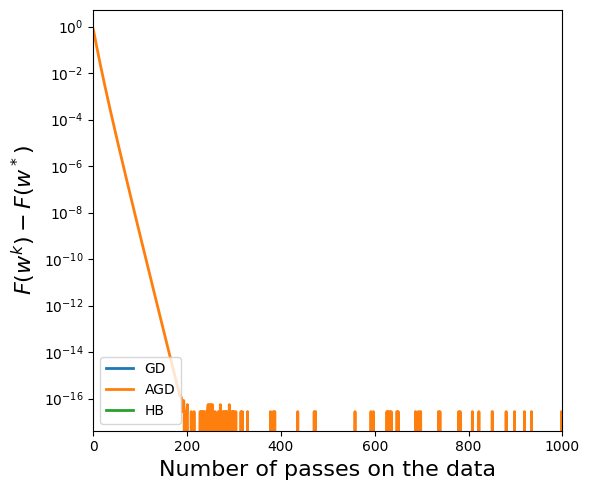

In [42]:
plt.figure(figsize=(6, 5))
plt.yscale("log")

for callback, name in zip(callbacks, names):
    objectives = np.array(callback.objectives)
    objectives_dist = objectives - obj_min    
    plt.plot(objectives_dist, label=name, lw=2)

plt.tight_layout()
plt.xlim((0, n_iter))
plt.xlabel("Number of passes on the data", fontsize=16)
plt.ylabel(r"$F(w^k) - F(w^*)$", fontsize=16)
plt.legend(loc='lower left')
plt.tight_layout()

# 5. And now logistic regression

## 5.1 Simulation of a logistic regression model

In [21]:
def sigmoid(t):
    """Sigmoid function (overflow-proof)"""
    idx = t > 0
    out = np.empty(t.size)    
    out[idx] = 1 / (1. + np.exp(-t[idx]))
    exp_t = np.exp(t[~idx])
    out[~idx] = exp_t / (1. + exp_t)
    return out

In [22]:
def simu_logreg(w0, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model with Gaussian features
    and a Toeplitz covariance.
    
    Parameters
    ----------
    w0 : `numpy.array`, shape=(n_features,)
        Model weights
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    X : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It contains samples of a centered 
        Gaussian vector with Toeplitz covariance.
    
    y : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    n_features = w0.shape[0]
    cov = toeplitz(corr ** np.arange(0, n_features))
    X = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(X.dot(w0))
    y = np.random.binomial(1, p, size=n_samples)
    # Put the label in {-1, 1}
    y[:] = 2 * y - 1
    return X, y


### Sanity check

Text(0.5, 1.0, 'Logistic regression simulation')

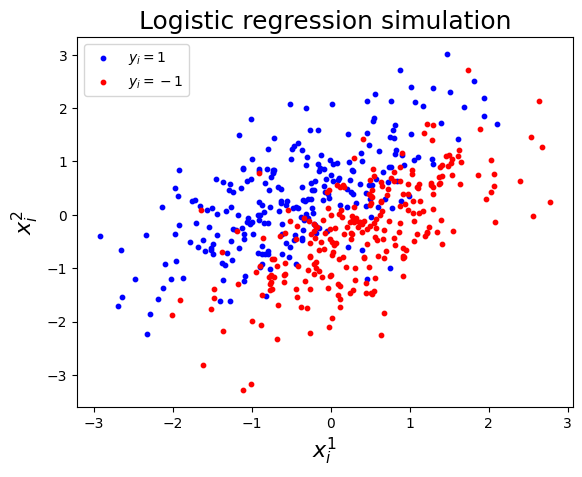

In [23]:
n_samples = 500
w0 = np.array([-3, 3.])

X, y = simu_logreg(w0, n_samples=n_samples, corr=0.4)

plt.scatter(*X[y == 1].T, color='b', s=10, label=r'$y_i=1$')
plt.scatter(*X[y == -1].T, color='r', s=10, label=r'$y_i=-1$')
plt.legend(loc='upper left')
plt.xlabel(r"$x_i^1$", fontsize=16)
plt.ylabel(r"$x_i^2$", fontsize=16)
plt.title("Logistic regression simulation", fontsize=18)

## 5.2 Model loss and gradient

We want to minimize a goodness-of-fit function $f$ with ridge regularization, namely
$$
\arg\min_{w \in \mathbb R^d} \Big\{ f(w) + \frac{\lambda}{2} \|w\|_2^2 \Big\}
$$
where $d$ is the number of features and where we will assume that $f$ is $L$-smooth.
We will consider below the following case:


**Logistic regression**, where
$$
f(w) = \frac 1n \sum_{i=1}^n f_i(w) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-y_i x_i^\top w)) + \frac{\lambda}{2} \|w\|_2^2,
$$
where $n$ is the sample size, and where labels $y_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f(w)$ and its gradient $\nabla f(w)$, in order to solve this problem, as well as $\nabla f_i(w)$ for stochastic gradient descent methods (and $\frac{\partial f(w)}{\partial w_j}$ for coordinate descent).


### QUESTIONS

<div class="alert alert-block alert-warning">

1. Compute (on paper) the gradient $\nabla f$, the gradient of $\nabla f_i$ and the gradient of the coordinate function $\frac{\partial f(w)}{\partial w_j}$ of $f$ for logistic regression (fill the class given below).

2. Fill in the functions below for the computation of $f$, $\nabla f$, $\nabla f_i$ and $\frac{\partial f(w)}{\partial w_j}$ for logistic regression in the ModelLogReg class below (fill between the TODO and END TODO)
</div>

In [ ]:
class ModelLogReg:
    """A class giving first order information for logistic regression
    
    Parameters
    ----------
    X : `numpy.array`, shape=(n_samples, n_features)
        The features matrix
    
    y : `numpy.array`, shape=(n_samples,)
        The vector of labels
    
    strength : `float`
        The strength of ridge penalization
    """    
    def __init__(self, X, y, strength):
        self.X = X
        self.y = y
        self.strength = strength
        self.n_samples, self.n_features = X.shape
    
    def loss(self, w):
        """Computes f(w)"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        ### TODO

        ### END TODO
       
    def grad(self, w):
        """Computes the gradient of f at w"""
        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
        ### TODO

        ### END TODO

##  (LATER)        
#    def grad_i(self, i, w):
#        """Computes the gradient of f_i at w"""
#        x_i = self.X[i], strength = self.strength
#        ### TODO
#
#        ### END TODO

#    def grad_coordinate(self, j, w):
#        """Computes the partial derivative of f with respect to 
#        the j-th coordinate"""
#        y, X, n_samples, strength = self.y, self.X, self.n_samples, self.strength
#        ### TODO
#
#        ### END TODO

    def lip(self):
        """Computes the Lipschitz constant of grad f"""
        X, n_samples = self.X, self.n_samples
        ### TODO

        ### END TODO

#    def lip_coordinates(self):
#        """Computes the Lipschitz constant of the derivative of f^j (f with respect to 
#        the j-th coordinate)"""
#        X, n_samples = self.X, self.n_samples
#        ### TODO
#
#        ### END TODO

    def lip_max(self):
        """Computes the maximum of the lipschitz constants of f_i"""
        X, n_samples = self.X, self.n_samples
        ### TODO

        ### END TODO

### Sanity check


<div class="alert alert-block alert-warning">

  Check numerically the gradient using the function ``checkgrad`` from ``scipy.optimize`` (see below), as we did for linear regression above
</div>

**Remark**: use the function `simu_logreg` to simulate data according to the logistic regression model

In [ ]:
from scipy.optimize import check_grad

X, y = simu_logreg(w0, corr=0.6)
model = ModelLogReg(X, y, strength=1e-3)

w = np.random.randn(n_features)

print(check_grad(model.loss, model.grad, w)) # This must be a number (of order 1e-6)

## 5.3 Solvers for logistic regression

<div class="alert alert-block alert-warning">
Re-use the solvers you already coded to perform logistic regression and plot the rate of convergence for all. 
</div>